# Let's make binary classification models:)
Here are some references:
Binary classification(1): https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa <br>
Binary classification(2): https://spark.apache.org/docs/2.2.0/ml-classification-regression.html <br>
Binary classification(3): https://docs.databricks.com/applications/machine-learning/mllib/binary-classification-mllib-pipelines.html <br>
Binary classification(4): https://wesslen.github.io/twitter/predicting_twitter_profile_location_with_pyspark/ <br>
Spark documentation: https://spark.apache.org/docs/2.2.0/ml-pipeline.html <br>
PySpark introduction: https://mleap-docs.combust.ml/getting-started/py-spark.html <br>
PySpark dataframe Tuturial: https://weiminwang.blog/2016/06/09/pyspark-tutorial-building-a-random-forest-binary-classifier-on-unbalanced-dataset/ <br>
Machine Learning with PySpark and MLlib — Solving a Binary Classification Problem: https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa <br>
Machine Learning PySpark and MLlib: https://github.com/susanli2016/PySpark-and-MLlib/blob/master/Machine%20Learning%20PySpark%20and%20MLlib.ipynb <br>
Random Forest feature importances: https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e <br>
Machine Learning with Text in PySpark: https://datascience-enthusiast.com/Python/PySpark_ML_with_Text_part1.html

## Configure Pyspark Environment

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-eu.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [0]:
import findspark
findspark.init("spark-2.4.4-bin-hadoop2.7") # SPARK_HOME
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
import os
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
!pwd
os.chdir('gdrive/Shared drives/ISE467 : Project 2&3/brazilian-ecommerce')
!pwd
!ls

In [0]:
final_order = spark.read.format('json').\
            load('/content/gdrive/Shared drives/brazilian-ecommerce/final_order.json')

In [0]:
final_order.printSchema()

root
 |-- Carrier_Late(1)/on-time(0): long (nullable = true)
 |-- Carrier_Start_Date-Shipping_limit_Days: double (nullable = true)
 |-- Carrier_time_diff_Days: double (nullable = true)
 |-- Delivery_time_diff_Days: double (nullable = true)
 |-- Estimated-Actual_Delivery_Days: double (nullable = true)
 |-- Late(1)/on-time(0): long (nullable = true)
 |-- Order_Approval_diff_Days: double (nullable = true)
 |-- Weight/volume: double (nullable = true)
 |-- customer_city: string (nullable = true)
 |-- customer_geolocation_lat: double (nullable = true)
 |-- customer_geolocation_lng: double (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- customer_state: string (nullable = true)
 |-- customer_unique_id: string (nullable = true)
 |-- customer_zip_code_prefix: long (nullable = true)
 |-- freight/price: double (nullable = true)
 |-- freight_value: double (nullable = true)
 |-- id: long (nullable = true)
 |-- order_approved_at: string (nullable = true)
 |-- order_delivered_carrier

## Let's change the data type!!

'review_creation_date', 'timestamp'
'review_answer_timestamp', 'timestamp'

In [0]:
final_order.show()

+--------------------------+--------------------------------------+----------------------+-----------------------+------------------------------+------------------+------------------------+-------------------+---------------+------------------------+------------------------+--------------------+--------------+--------------------+------------------------+-------------------+-------------+---+--------------------+----------------------------+-----------------------------+-----------------------------+--------------------+-------------+------------------------+------------+--------------------+--------------------+-----+-----------------------------+--------------------------+-----------------+--------------------+-----------------+-------------------+------------------+----------------+----------------+----------------------+--------------------+------------+-----------+----------------------+----------------------+--------------------+------------+----------------------+---------------

In [0]:
from pyspark.sql import functions as F

format = "yyyy-MM-dd'T'HH:mm:ss"
final_order = final_order.withColumn('order_purchase_timestamp', F.unix_timestamp('order_purchase_timestamp', format).cast('timestamp'))\
                         .withColumn("order_approved_at", F.unix_timestamp("order_approved_at", format).cast('timestamp'))\
                         .withColumn("order_delivered_carrier_date", F.unix_timestamp("order_delivered_carrier_date", format).cast('timestamp'))\
                         .withColumn("order_delivered_customer_date", F.unix_timestamp("order_delivered_customer_date", format).cast('timestamp'))\
                         .withColumn("order_estimated_delivery_date", F.unix_timestamp("order_estimated_delivery_date", format).cast('timestamp'))\
                         .withColumn("shipping_limit_date", F.unix_timestamp("shipping_limit_date", format).cast('timestamp'))                   

In [0]:
# from pyspark.sql.functions import to_timestamp
# import pyspark.sql.functions as F
# final_order = final_order.withColumn("order_purchase_timestamp", F.to_timestamp("order_purchase_timestamp", format='MM/dd/yyyy HH:mm'))\
#                          .withColumn("order_approved_at", F.to_timestamp("order_approved_at", format='MM/dd/yyyy HH:mm'))\
#                          .withColumn("order_delivered_carrier_date", F.to_timestamp("order_delivered_carrier_date", format='MM/dd/yyyy HH:mm'))\
#                          .withColumn("order_delivered_customer_date", F.to_timestamp("order_delivered_customer_date", format='MM/dd/yyyy HH:mm'))\
#                          .withColumn("order_estimated_delivery_date", F.to_timestamp("order_estimated_delivery_date", format='MM/dd/yyyy HH:mm'))

In [0]:
final_order.show()

+--------------------------+--------------------------------------+----------------------+-----------------------+------------------------------+------------------+------------------------+-------------------+---------------+------------------------+------------------------+--------------------+--------------+--------------------+------------------------+-------------------+-------------+---+-------------------+----------------------------+-----------------------------+-----------------------------+--------------------+-------------+------------------------+------------+--------------------+--------------------+-----+-----------------------------+--------------------------+-----------------+--------------------+-----------------+-------------------+------------------+----------------+----------------+----------------------+--------------------+------------+-----------+----------------------+----------------------+--------------------+------------+----------------------+----------------

In [0]:
## change "review score" to IntegerType
from pyspark.sql.types import IntegerType
final_order = final_order.withColumn("review_score", final_order["review_score"].cast(IntegerType()))

## Create the variable "Distance Between Seller Coordinates and Customer Coordinates"

In [0]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql import DataFrameWriter as W
from math import radians, cos, sin, asin, sqrt

In [0]:
def get_distance(longit_a, latit_a, longit_b, latit_b):
  # Transform to radians
  longit_a, latit_a, longit_b, latit_b = map(radians, [longit_a,  latit_a, longit_b, latit_b])
  dist_longit =  (longit_b - longit_a)
  dist_latit = latit_b - latit_a
  # Calculate area
  area = sin(dist_latit/2)**2 + cos(latit_a) * cos(latit_b) * sin(dist_longit/2)**2
  # Calculate the central angle
  central_angle = 2 * asin(sqrt(area))
  radius = 6371
  # Calculate Distance
  distance = central_angle * radius
  return abs(round(distance, 2))
udf_get_distance = F.udf(get_distance)

In [0]:
get_distance(-43.20710147,-22.98392343,-51.96120191,-29.44657989)

1130.2

In [0]:
x = udf_get_distance(final_order['customer_geolocation_lng'],final_order['customer_geolocation_lat'],final_order['seller_geolocation_lng'],final_order['seller_geolocation_lat'])
final_order = final_order.withColumn("Distance_Sell_Cust", x)
final_order = final_order.withColumn("Distance_Sell_Cust", final_order["Distance_Sell_Cust"].cast(FloatType()))
final_order.show()

+--------------------------+--------------------------------------+----------------------+-----------------------+------------------------------+------------------+------------------------+-------------------+---------------+------------------------+------------------------+--------------------+--------------+--------------------+------------------------+-------------------+-------------+---+-------------------+----------------------------+-----------------------------+-----------------------------+--------------------+-------------+------------------------+------------+--------------------+--------------------+-----+-----------------------------+--------------------------+-----------------+--------------------+-----------------+-------------------+------------------+----------------+----------------+----------------------+--------------------+------------+-----------+----------------------+----------------------+--------------------+------------+----------------------+----------------

## Exploring The Data
We will use the brazilian e-commerce data set when we built binary Classification models in Pyspark, and it is related to olist e-commerce data set in Brazil. The classification goal is to predict whether the product will be delivered (On-time/Lately) to a customer. The dataset can be downloaded from Kaggle.

In [0]:
final_order.printSchema()

root
 |-- Carrier_Late(1)/on-time(0): long (nullable = true)
 |-- Carrier_Start_Date-Shipping_limit_Days: double (nullable = true)
 |-- Carrier_time_diff_Days: double (nullable = true)
 |-- Delivery_time_diff_Days: double (nullable = true)
 |-- Estimated-Actual_Delivery_Days: double (nullable = true)
 |-- Late(1)/on-time(0): long (nullable = true)
 |-- Order_Approval_diff_Days: double (nullable = true)
 |-- Weight/volume: double (nullable = true)
 |-- customer_city: string (nullable = true)
 |-- customer_geolocation_lat: double (nullable = true)
 |-- customer_geolocation_lng: double (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- customer_state: string (nullable = true)
 |-- customer_unique_id: string (nullable = true)
 |-- customer_zip_code_prefix: long (nullable = true)
 |-- freight/price: double (nullable = true)
 |-- freight_value: double (nullable = true)
 |-- id: long (nullable = true)
 |-- order_approved_at: timestamp (nullable = true)
 |-- order_delivered_carr

In [0]:
final_order.show()

+--------------------------+--------------------------------------+----------------------+-----------------------+------------------------------+------------------+------------------------+-------------------+---------------+------------------------+------------------------+--------------------+--------------+--------------------+------------------------+-------------------+-------------+---+-------------------+----------------------------+-----------------------------+-----------------------------+--------------------+-------------+------------------------+------------+--------------------+--------------------+-----+-----------------------------+--------------------------+-----------------+--------------------+-----------------+-------------------+------------------+----------------+----------------+----------------------+--------------------+------------+-----------+----------------------+----------------------+--------------------+------------+----------------------+----------------

In [0]:
print final_order.columns ## Column Names
print "Row Count: ", final_order.count() ## Row Count
print "Column Count: ", len(final_order.columns) ## Column Count

['Carrier_Late(1)/on-time(0)', 'Carrier_Start_Date-Shipping_limit_Days', 'Carrier_time_diff_Days', 'Delivery_time_diff_Days', 'Estimated-Actual_Delivery_Days', 'Late(1)/on-time(0)', 'Order_Approval_diff_Days', 'Weight/volume', 'customer_city', 'customer_geolocation_lat', 'customer_geolocation_lng', 'customer_id', 'customer_state', 'customer_unique_id', 'customer_zip_code_prefix', 'freight/price', 'freight_value', 'id', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'order_id', 'order_item_id', 'order_purchase_timestamp', 'order_status', 'payment_type_count', 'payment_type_value', 'price', 'product_category_name_english', 'product_description_lenght', 'product_height_cm', 'product_id', 'product_length_cm', 'product_name_lenght', 'product_photos_qty', 'product_weight_g', 'product_width_cm', 'review_comment_message', 'review_id', 'review_score', 'seller_city', 'seller_geolocation_lat', 'seller_geolocation_lng', 'selle

In [0]:
final_order.columns

['Carrier_Late(1)/on-time(0)',
 'Carrier_Start_Date-Shipping_limit_Days',
 'Carrier_time_diff_Days',
 'Delivery_time_diff_Days',
 'Estimated-Actual_Delivery_Days',
 'Late(1)/on-time(0)',
 'Order_Approval_diff_Days',
 'Weight/volume',
 'customer_city',
 'customer_geolocation_lat',
 'customer_geolocation_lng',
 'customer_id',
 'customer_state',
 'customer_unique_id',
 'customer_zip_code_prefix',
 'freight/price',
 'freight_value',
 'id',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'order_id',
 'order_item_id',
 'order_purchase_timestamp',
 'order_status',
 'payment_type_count',
 'payment_type_value',
 'price',
 'product_category_name_english',
 'product_description_lenght',
 'product_height_cm',
 'product_id',
 'product_length_cm',
 'product_name_lenght',
 'product_photos_qty',
 'product_weight_g',
 'product_width_cm',
 'review_comment_message',
 'review_id',
 'review_score',
 'seller_city',
 'seller_geolocat

Input variables: 'Weight/volume',
 'customer_city'
 'customer_state',
 'customer_zip_code_prefix',
 'freight/price',
 'freight_value',
 'order_status',
 'payment_type_count',
 'payment_type_value',
 'price',
 'product_height_cm',
 'product_id',
 'product_length_cm',
 'product_name_lenght',
 'product_photos_qty',
 'product_weight_g',
 'product_width_cm',
 'review_score',
 'seller_city',
 'seller_state',
 'seller_zip_code_prefix',
 'shipping_limit_date',
 'total_payment',
 'Distance_Sell_Cust'<br>
Output variable: Late(1)/on-time(0) <br>
### Have a peek of the first five observations. Pandas data frame is prettier than Spark DataFrame.show().

In [0]:
import pandas as pd
pd.DataFrame(final_order.take(5), columns=final_order.columns).transpose()

,0,1,2,3,4
Carrier_Late(1)/on-time(0),0,0,1,1,1
Carrier_Start_Date-Shipping_limit_Days,1.85584,1.00558,-23.7699,-0.115891,-0.169606
Carrier_time_diff_Days,20.1924,6.99722,6.01736,3.02708,3.09792
Delivery_time_diff_Days,28.2333,11.9917,36.8958,9.15417,11.1125
Estimated-Actual_Delivery_Days,2.32847,8.33056,-9.89514,10.4646,7.28542
Late(1)/on-time(0),0,0,1,0,0
Order_Approval_diff_Days,0.896528,0,1.10833,0.0111111,1.84444
Weight/volume,0.0475146,0.107962,0.107962,0.253968,0.253968
customer_city,brasilia,concordia,catanduva,sao jose,nova prata
customer_geolocation_lat,-16.0229,-27.2309,-21.121,-27.5958,-28.7823


### Check the balanced target.

In [0]:
import pandas as pd
pd.DataFrame(final_order.take(5), columns=final_order.columns).transpose()

,0,1,2,3,4
Carrier_Late(1)/on-time(0),0,0,1,1,1
Carrier_Start_Date-Shipping_limit_Days,1.85584,1.00558,-23.7699,-0.115891,-0.169606
Carrier_time_diff_Days,20.1924,6.99722,6.01736,3.02708,3.09792
Delivery_time_diff_Days,28.2333,11.9917,36.8958,9.15417,11.1125
Estimated-Actual_Delivery_Days,2.32847,8.33056,-9.89514,10.4646,7.28542
Late(1)/on-time(0),0,0,1,0,0
Order_Approval_diff_Days,0.896528,0,1.10833,0.0111111,1.84444
Weight/volume,0.0475146,0.107962,0.107962,0.253968,0.253968
customer_city,brasilia,concordia,catanduva,sao jose,nova prata
customer_geolocation_lat,-16.0229,-27.2309,-21.121,-27.5958,-28.7823


### Summary statistics for numeric variables

In [0]:
numeric_features = [t[0] for t in final_order.dtypes if t[1] == 'int' or t[1] == 'double']
final_order.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Carrier_Start_Date-Shipping_limit_Days,111458,3.323449424646255,6.611830825323372,-116.76210648148148,1054.244699074074
Carrier_time_diff_Days,110204,9.187476388485582,8.625245730872752,-16.096527777777776,205.19097222222223
Delivery_time_diff_Days,110204,12.471911661806976,9.445657264937694,0.5333333333333333,209.62847222222223
Estimated-Actual_Delivery_Days,110204,11.33420883719683,10.162360341914734,-188.975,146.01666666666668
Order_Approval_diff_Days,112650,0.4407822717857845,0.9300477452053918,0.0,60.452777777777776
Weight/volume,112650,0.19165509869709305,0.7843924552475219,0.0,85.22727272727273
customer_geolocation_lat,112650,-21.21992533847987,5.574039609879062,-33.68994828,42.18400274
customer_geolocation_lng,112650,-46.2032264634759,4.0369486040187095,-72.66888054,-8.723762148
freight/price,112650,0.32086354907978043,0.3498936787366237,0.0,26.23529411764706


### Correlations between independent variables.

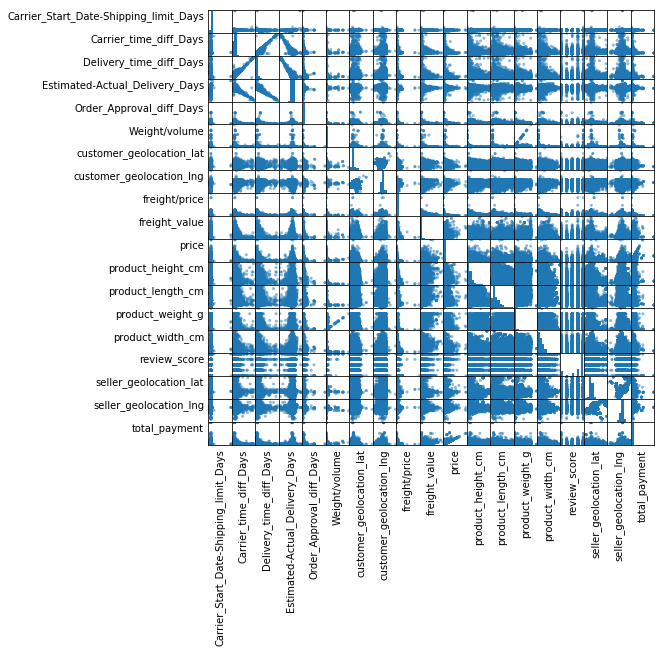

In [0]:
numeric_data = final_order.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

(Write down Interpretation) e.g .... It’s obvious that there aren’t highly correlated numeric variables. Therefore, we will keep all of them for the model. However, day and month columns are not really useful, we will remove these two columns.

In [0]:
cols = final_order.columns
final_order.printSchema()

root
 |-- Carrier_Late(1)/on-time(0): long (nullable = true)
 |-- Carrier_Start_Date-Shipping_limit_Days: double (nullable = true)
 |-- Carrier_time_diff_Days: double (nullable = true)
 |-- Delivery_time_diff_Days: double (nullable = true)
 |-- Estimated-Actual_Delivery_Days: double (nullable = true)
 |-- Late(1)/on-time(0): long (nullable = true)
 |-- Order_Approval_diff_Days: double (nullable = true)
 |-- Weight/volume: double (nullable = true)
 |-- customer_city: string (nullable = true)
 |-- customer_geolocation_lat: double (nullable = true)
 |-- customer_geolocation_lng: double (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- customer_state: string (nullable = true)
 |-- customer_unique_id: string (nullable = true)
 |-- customer_zip_code_prefix: long (nullable = true)
 |-- freight/price: double (nullable = true)
 |-- freight_value: double (nullable = true)
 |-- id: long (nullable = true)
 |-- order_approved_at: timestamp (nullable = true)
 |-- order_delivered_carr

### data visualization

In [0]:
# convert spark dataframe to pandas for visualization
final_order_df = final_order.toPandas()

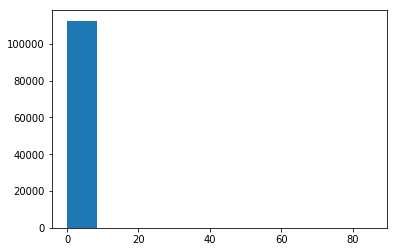

In [0]:
import matplotlib.pyplot as plt
plt.hist(final_order_df['Weight/volume'])
plt.show()

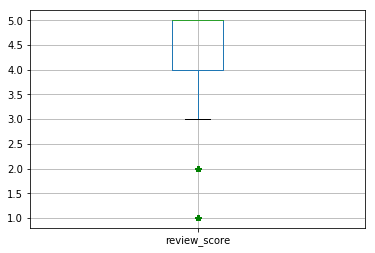

In [0]:
#Check outlier in numerical variable
final_order_df[["review_score"]].boxplot(sym='g-*', grid=True)
plt.show()

## Preparing Data for Machine Learning
### Feature Engineering
Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. It is fundamental to the application of machine learning and helps in increasing the accuracy of the model. It is really essential in creating the right features.I will be using Random Forest Regressor model for this data. So, I split the date into discrete components so the decision trees were able to make better guesses.
Let's look through it deeply. 80 percent of a data scientist's valuable time is spent simply finding, cleansing, and organizing data, leaving only 20 percent to actually perform analysis. According to this part, our analysis can be more accurate and build better models.

### Check the number of variables in target.

In [0]:
from pyspark.sql.functions import col
final_order.groupBy("Late(1)/on-time(0)") \
            .count() \
            .orderBy(col("count").desc()) \
            .show()

+------------------+------+
|Late(1)/on-time(0)| count|
+------------------+------+
|                 0|103935|
|                 1|  8715|
+------------------+------+



### Check the missing values

In [0]:
#final_order_df = final_order.toPandas()

In [0]:
final_order_df.isnull().sum() # check the missing values

Carrier_Late(1)/on-time(0)                    0
Carrier_Start_Date-Shipping_limit_Days     1192
Carrier_time_diff_Days                     2446
Delivery_time_diff_Days                    2446
Estimated-Actual_Delivery_Days             2446
Late(1)/on-time(0)                            0
Order_Approval_diff_Days                      0
Weight/volume                                 0
customer_city                                 0
customer_geolocation_lat                      0
customer_geolocation_lng                      0
customer_id                                   0
customer_state                                0
customer_unique_id                            0
customer_zip_code_prefix                      0
freight/price                                 0
freight_value                                 0
id                                            0
order_approved_at                             0
order_delivered_carrier_date               1192
order_delivered_customer_date           

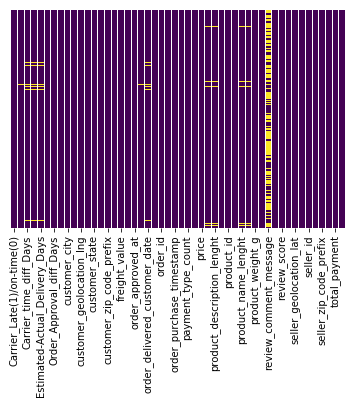

In [0]:
import seaborn as sns
sns.heatmap(final_order_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [0]:
missing_data = final_order_df.isnull()
missing_data.head(5)

,Carrier_Late(1)/on-time(0),Carrier_Start_Date-Shipping_limit_Days,Carrier_time_diff_Days,Delivery_time_diff_Days,Estimated-Actual_Delivery_Days,Late(1)/on-time(0),Order_Approval_diff_Days,Weight/volume,customer_city,customer_geolocation_lat,customer_geolocation_lng,customer_id,customer_state,customer_unique_id,customer_zip_code_prefix,freight/price,freight_value,id,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_id,order_item_id,order_purchase_timestamp,order_status,payment_type_count,payment_type_value,price,product_category_name_english,product_description_lenght,product_height_cm,product_id,product_length_cm,product_name_lenght,product_photos_qty,product_weight_g,product_width_cm,review_comment_message,review_id,review_score,seller_city,seller_geolocation_lat,seller_geolocation_lng,seller_id,seller_state,seller_zip_code_prefix,shipping_limit_date,total_payment,Distance_Sell_Cust
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False


In [0]:
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")

Carrier_Late(1)/on-time(0)
False    112650
Name: Carrier_Late(1)/on-time(0), dtype: int64

Carrier_Start_Date-Shipping_limit_Days
False    111458
True       1192
Name: Carrier_Start_Date-Shipping_limit_Days, dtype: int64

Carrier_time_diff_Days
False    110204
True       2446
Name: Carrier_time_diff_Days, dtype: int64

Delivery_time_diff_Days
False    110204
True       2446
Name: Delivery_time_diff_Days, dtype: int64

Estimated-Actual_Delivery_Days
False    110204
True       2446
Name: Estimated-Actual_Delivery_Days, dtype: int64

Late(1)/on-time(0)
False    112650
Name: Late(1)/on-time(0), dtype: int64

Order_Approval_diff_Days
False    112650
Name: Order_Approval_diff_Days, dtype: int64

Weight/volume
False    112650
Name: Weight/volume, dtype: int64

customer_city
False    112650
Name: customer_city, dtype: int64

customer_geolocation_lat
False    112650
Name: customer_geolocation_lat, dtype: int64

customer_geolocation_lng
False    112650
Name: customer_geolocation_lng, dtype: int6

### Correlation matrix

In [0]:
from pyspark.mllib.stat import Statistics 
import pandas as pd

corr_data = final_order.select(numeric_features)
col_names = corr_data.columns
features = corr_data.rdd.map(lambda row: row[0:]) 
corr_mat=Statistics.corr(features, method="pearson") 
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names
print(corr_df.to_string())

                                        Carrier_Start_Date-Shipping_limit_Days  Carrier_time_diff_Days  Delivery_time_diff_Days  Estimated-Actual_Delivery_Days  Order_Approval_diff_Days  Weight/volume  customer_geolocation_lat  customer_geolocation_lng  freight/price  freight_value     price  product_height_cm  product_length_cm  product_weight_g  product_width_cm  review_score  seller_geolocation_lat  seller_geolocation_lng  total_payment
Carrier_Start_Date-Shipping_limit_Days                                     1.0                     NaN                      NaN                             NaN                       NaN            NaN                       NaN                       NaN            NaN            NaN       NaN                NaN                NaN               NaN               NaN           NaN                     NaN                     NaN            NaN
Carrier_time_diff_Days                                                     NaN                     1.0          

In [0]:
df = corr_data.toPandas()

In [0]:
df.corr()

,Carrier_Start_Date-Shipping_limit_Days,Carrier_time_diff_Days,Delivery_time_diff_Days,Estimated-Actual_Delivery_Days,Order_Approval_diff_Days,Weight/volume,customer_geolocation_lat,customer_geolocation_lng,freight/price,freight_value,price,product_height_cm,product_length_cm,product_weight_g,product_width_cm,review_score,seller_geolocation_lat,seller_geolocation_lng,total_payment
Carrier_Start_Date-Shipping_limit_Days,1.000000,0.009801,-0.145491,0.249941,0.013222,0.002211,0.003218,-0.007476,0.002250,-0.004096,-0.009332,-0.011804,-0.006217,-0.007860,-0.005230,0.059610,-0.002524,0.003922,-0.016662
Carrier_time_diff_Days,0.009801,1.000000,0.922243,-0.569346,0.008027,0.016982,0.277310,0.114376,0.076695,0.196069,0.040988,0.016399,0.037506,0.030777,0.019582,-0.269047,0.057421,-0.040257,0.028125
Delivery_time_diff_Days,-0.145491,0.922243,1.000000,-0.596844,0.084380,0.015105,0.257545,0.108839,0.067113,0.214694,0.062373,0.066933,0.068756,0.085714,0.039585,-0.305274,0.052178,-0.042340,0.062927
Estimated-Actual_Delivery_Days,0.249941,-0.569346,-0.596844,1.000000,-0.042496,-0.008147,0.012000,-0.050824,0.028578,0.040388,0.003787,0.001502,-0.010089,-0.011315,-0.000790,0.229762,-0.015749,-0.024324,0.021098
Order_Approval_diff_Days,0.013222,0.008027,0.084380,-0.042496,1.000000,-0.000559,0.019434,-0.013384,0.028925,0.031418,0.014379,0.008019,0.006981,0.011274,0.001731,-0.024954,-0.003814,0.003223,0.052039
Weight/volume,0.002211,0.016982,0.015105,-0.008147,-0.000559,1.000000,0.013191,0.008688,-0.014486,0.043243,0.038490,-0.067765,-0.047504,0.130399,-0.054447,0.002129,0.008380,-0.001525,0.044380
customer_geolocation_lat,0.003218,0.277310,0.257545,0.012000,0.019434,0.013191,1.000000,0.446374,0.122289,0.272969,0.056829,-0.005230,-0.017693,0.002577,-0.019750,-0.038285,0.084564,0.084824,0.061134
customer_geolocation_lng,-0.007476,0.114376,0.108839,-0.050824,-0.013384,0.008688,0.446374,1.000000,0.034260,0.093498,0.018706,-0.006789,-0.011036,0.002135,-0.005870,-0.047084,0.074410,0.082288,0.015719
freight/price,0.002250,0.076695,0.067113,0.028578,0.028925,-0.014486,0.122289,0.034260,1.000000,0.088493,-0.291402,-0.107036,-0.096236,-0.104067,-0.115623,-0.037783,-0.008640,-0.009470,-0.206366
freight_value,-0.004096,0.196069,0.214694,0.040388,0.031418,0.043243,0.272969,0.093498,0.088493,1.000000,0.414204,0.391826,0.309082,0.610412,0.323773,-0.036267,0.038514,-0.004322,0.386453


In [0]:
# import seaborn as sns 
# sns.set(style="ticks")
# sns.pairplot(df) 
# plt.show()

### The process includes Category Indexing, One-Hot Encoding and VectorAssembler — a feature transformer that merges multiple columns into a vector column.

In [0]:
final_order.printSchema()

root
 |-- Carrier_Late(1)/on-time(0): long (nullable = true)
 |-- Carrier_Start_Date-Shipping_limit_Days: double (nullable = true)
 |-- Carrier_time_diff_Days: double (nullable = true)
 |-- Delivery_time_diff_Days: double (nullable = true)
 |-- Estimated-Actual_Delivery_Days: double (nullable = true)
 |-- Late(1)/on-time(0): long (nullable = true)
 |-- Order_Approval_diff_Days: double (nullable = true)
 |-- Weight/volume: double (nullable = true)
 |-- customer_city: string (nullable = true)
 |-- customer_geolocation_lat: double (nullable = true)
 |-- customer_geolocation_lng: double (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- customer_state: string (nullable = true)
 |-- customer_unique_id: string (nullable = true)
 |-- customer_zip_code_prefix: long (nullable = true)
 |-- freight/price: double (nullable = true)
 |-- freight_value: double (nullable = true)
 |-- id: long (nullable = true)
 |-- order_approved_at: timestamp (nullable = true)
 |-- order_delivered_carr

In [0]:
final_order.columns

['Carrier_Late(1)/on-time(0)',
 'Carrier_Start_Date-Shipping_limit_Days',
 'Carrier_time_diff_Days',
 'Delivery_time_diff_Days',
 'Estimated-Actual_Delivery_Days',
 'Late(1)/on-time(0)',
 'Order_Approval_diff_Days',
 'Weight/volume',
 'customer_city',
 'customer_geolocation_lat',
 'customer_geolocation_lng',
 'customer_id',
 'customer_state',
 'customer_unique_id',
 'customer_zip_code_prefix',
 'freight/price',
 'freight_value',
 'id',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'order_id',
 'order_item_id',
 'order_purchase_timestamp',
 'order_status',
 'payment_type_count',
 'payment_type_value',
 'price',
 'product_category_name_english',
 'product_description_lenght',
 'product_height_cm',
 'product_id',
 'product_length_cm',
 'product_name_lenght',
 'product_photos_qty',
 'product_weight_g',
 'product_width_cm',
 'review_comment_message',
 'review_id',
 'review_score',
 'seller_city',
 'seller_geolocat

### Data Wrangling
now that we have some ideas about the general structure of our dataset, let’s continue with some data wrangling. first we check how many Categorical and Numerical features do we have. next we build a function that outputs essential information about the missing values in our dataset:

In [0]:
# now let's see how many categorical and numerical features we have:
cat_cols = [item[0] for item in final_order.dtypes if item[1].startswith('string')] 
print(str(len(cat_cols)) + '  categorical features')
num_cols = [item[0] for item in final_order.dtypes if item[1].startswith('int') | item[1].startswith('double')][1:]
print(str(len(num_cols)) + '  numerical features')

13  categorical features
18  numerical features


In [0]:
# we use the below function to find more information about the #missing values
def info_missing_table(df_pd):
    """Input pandas dataframe and Return columns with missing value and percentage"""
    mis_val = df_pd.isnull().sum() #count total of null in each columns in dataframe
#count percentage of null in each columns
    mis_val_percent = 100 * df_pd.isnull().sum() / len(df_pd) 
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1) 
 #join to left (as column) between mis_val and mis_val_percent
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'}) 
#rename columns in table
    mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1) 
        
    print ("Your selected dataframe has " + str(df_pd.shape[1]) + " columns.\n"    #.shape[1] : just view total columns in dataframe  
    "There are " + str(mis_val_table_ren_columns.shape[0]) +              
    " columns that have missing values.") #.shape[0] : just view total rows in dataframe
    return mis_val_table_ren_columns
missings = info_missing_table(final_order_df)
missings

Your selected dataframe has 50 columns.
There are 14 columns that have missing values.


,Missing Values,% of Total Values
review_comment_message,64296,57.1
Carrier_time_diff_Days,2446,2.2
Delivery_time_diff_Days,2446,2.2
Estimated-Actual_Delivery_Days,2446,2.2
order_delivered_customer_date,2446,2.2
product_category_name_english,1627,1.4
product_description_lenght,1603,1.4
product_name_lenght,1603,1.4
product_photos_qty,1603,1.4
Carrier_Start_Date-Shipping_limit_Days,1192,1.1


'Weight/volume',
 'customer_city'
 'customer_state',
 'customer_zip_code_prefix',
 'freight/price',
 'freight_value',
 'order_status',
 'payment_type_count',
 'payment_type_value',
 'price',
 'product_height_cm',
 'product_id',
 'product_length_cm',
 'product_name_lenght',
 'product_photos_qty',
 'product_weight_g',
 'product_width_cm',
 'review_score',
 'seller_city',
 'seller_state',
 'seller_zip_code_prefix',
 'shipping_limit_date',
 'total_payment',
 'Distance_Sell_Cust'

### Feature Engineering
the next step is Feature Engineering. pySpark has made it so easy that we do not need to do much for extracting features. here are the steps:
we apply StringIndexer() to assign indices to each category in our categorical columns.
we apply OneHotEncoderEstimator() to convert categorical columns to onehot encoded vectors. First, we need to use the String Indexer to convert the variable into numerical form and then use OneHotEncoderEstimator to encode multiple columns of the dataset.
and we apply VectorAssembler() to create a feature vector from all categorical and numerical features and we call the final vector as “features”. <br>
Reference: https://www.analyticsvidhya.com/blog/2019/11/build-machine-learning-pipelines-pyspark/

<ol>
    <li> String Indexer: String Indexer encodes a column of string label/categories to a column of indices. The ordering of the indices is done on the basis of popularity and the range is [0, numOflabels).
    </li>
    <li> One Hot Encoder: One hot encoder maps the label indices to a binary vector representation with at the most a single one-value. These methods are generally used when we need to use categorical features but the algorithm expects continuous features. The spark one hot encoder takes the indexed label/category from the string indexer and then encodes it into a sparse vector. This is slightly different from the usual dummy column creation style. At this point, we would like to point out the sparse vector has 4 different components. The first component which is a 0 indicates that it is a sparse vector. The second component talks about the size of the vector. The second component talks about the size of the vector. The third component talks about the indices where the vector is populated while the fourth component talks about what values these are. This truncates the vector and is really efficient when you have really large vector representations. If we want to see the dense vector representation for this, it is very easy to use a udf to transform this. </li>
    <li> Vector Assembler: Vector Assembler is to combine the raw features and features generated from various transforms into a single feature vector. It accepts boolean, numerical and vector type inputs). Vector assembler combine all our features into one before training our models. </li>
    <li> Pipeline: A Pipeline chains multiple Transformers and Estimators together to specify an ML workflow. </li>
</ol>


In [0]:
# we use the OneHotEncoderEstimator from MLlib in spark to convert #aech v=categorical feature into one-hot vectors
# next, we use VectorAssembler to combine the resulted one-hot ector #and the rest of numerical features into a 
# single vector column. we append every step of the process in a #stages array
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
categoricalColumns = ['customer_city', 'customer_state', 'seller_city', 'seller_state']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + '_Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "_classVec"])
    stages += [stringIndexer, encoder]
    # stages += [stringIndexer]

label_stringIdx = StringIndexer(inputCol = 'Late(1)/on-time(0)', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['Weight/volume',  'customer_zip_code_prefix', 'freight/price',  'freight_value', 'price',\
               'product_height_cm', 'product_length_cm', \
               'product_weight_g', 'product_width_cm', 'review_score', 'seller_zip_code_prefix','Distance_Sell_Cust'] # 'product_photos_qty','total_payment'
assemblerInputs = [c + "_classVec" for c in categoricalColumns] + numericCols
assemblerInputs = numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]
# payment_type_count, payment_type_value, product_name_lenght, product_photos_qty, total_payment

### Pipeline
We use Pipeline to chain multiple Transformers and Estimators together to specify our machine learning workflow. A Pipeline’s stages are specified as an ordered array.

In [0]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(final_order)
final_order2 = pipelineModel.transform(final_order)
selectedCols = ['label', 'features'] + cols
final_order3 = final_order2.select(selectedCols)
final_order3.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- Carrier_Late(1)/on-time(0): long (nullable = true)
 |-- Carrier_Start_Date-Shipping_limit_Days: double (nullable = true)
 |-- Carrier_time_diff_Days: double (nullable = true)
 |-- Delivery_time_diff_Days: double (nullable = true)
 |-- Estimated-Actual_Delivery_Days: double (nullable = true)
 |-- Late(1)/on-time(0): long (nullable = true)
 |-- Order_Approval_diff_Days: double (nullable = true)
 |-- Weight/volume: double (nullable = true)
 |-- customer_city: string (nullable = true)
 |-- customer_geolocation_lat: double (nullable = true)
 |-- customer_geolocation_lng: double (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- customer_state: string (nullable = true)
 |-- customer_unique_id: string (nullable = true)
 |-- customer_zip_code_prefix: long (nullable = true)
 |-- freight/price: double (nullable = true)
 |-- freight_value: double (nullable = true)
 |-- id: long (nullable = true)

In [0]:
final_order3.show()

+-----+--------------------+--------------------------+--------------------------------------+----------------------+-----------------------+------------------------------+------------------+------------------------+-------------------+---------------+------------------------+------------------------+--------------------+--------------+--------------------+------------------------+-------------------+-------------+---+-------------------+----------------------------+-----------------------------+-----------------------------+--------------------+-------------+------------------------+------------+--------------------+--------------------+-----+-----------------------------+--------------------------+-----------------+--------------------+-----------------+-------------------+------------------+----------------+----------------+----------------------+--------------------+------------+-----------+----------------------+----------------------+--------------------+------------+------------

In [0]:
pd.DataFrame(final_order3.take(5), columns=final_order3.columns).transpose()

,0,1,2,3,4
label,0,0,1,0,0
features,"[0.04751461988304093, 72457.0, 0.2629536921151...","[0.10796221322537113, 89705.0, 0.3465393794749...","[0.10796221322537113, 15804.0, 0.4276849642004...","[0.25396825396825395, 88102.0, 0.3603818615751...","[0.25396825396825395, 95320.0, 0.2978520286396..."
Carrier_Late(1)/on-time(0),0,0,1,1,1
Carrier_Start_Date-Shipping_limit_Days,1.85584,1.00558,-23.7699,-0.115891,-0.169606
Carrier_time_diff_Days,20.1924,6.99722,6.01736,3.02708,3.09792
Delivery_time_diff_Days,28.2333,11.9917,36.8958,9.15417,11.1125
Estimated-Actual_Delivery_Days,2.32847,8.33056,-9.89514,10.4646,7.28542
Late(1)/on-time(0),0,0,1,0,0
Order_Approval_diff_Days,0.896528,0,1.10833,0.0111111,1.84444
Weight/volume,0.0475146,0.107962,0.107962,0.253968,0.253968


([<matplotlib.axis.XTick at 0x7fb4d7786090>,
 <a list of 2 Text xticklabel objects>)

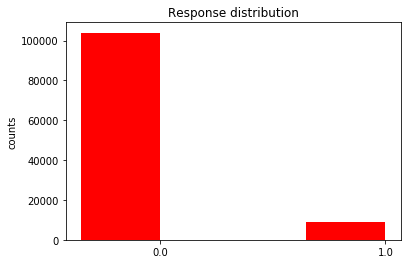

In [0]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
 
responses = final_order3.groupBy("label").count().collect()
categories = [i[0] for i in responses]
counts = [i[1] for i in responses]
 
ind = np.array(range(len(categories)))
width = 0.35
plt.bar(ind, counts, width=width, color='r')
 
plt.ylabel('counts')
plt.title('Response distribution')
plt.xticks(ind + width/2., categories)

Since unbalanced data set is a very common in real business world, this tutorial will specifically showcase some of the tactics that could effectively deal with such challenge using PySpark.

In binary classification problems, accuracy can be misleading if one class s much more common than another, this is when the classes are unbalanced.

The distribution looks quite skewed. There are some techniques to handle the imbalanced data sets. https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/

### Split data into training (70%) and testing (30%)
We will split the dataframe into training and test sets, traing on the first dataset, and then evaluate on the held-out test set.
As you can see, we now have features column and label column.
Randomly split data into train and test sets, and set seed for reproducibility.

In [0]:
train, test = final_order3.randomSplit([0.7, 0.3], seed = 2019) # If there are some missing values in columns, it makes some errors.
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 78896
Test Dataset Count: 33754


## Predict the on-time delivery with binary classification models
The models presented are:

Logistic regression
Naive Bayes
Random forest
Each model building code section is split into steps:

Model training data with one parameter set
Model evaluation on a test data set with metrics

### Logistic Regression Model

Logistic regression is a popular method to predict a categorical response. it is a special case of Generalized Linear models that predicts the probability of the outcomes. In spark.ml logistic regression can be used to predict a binary outcome by using binomial logistic regression, or it can be used to predict a multiclass outcome by using multinomial logistic regression. Use the family parameter to select between these two algorithms, or leave it unset and Spark will infer the correct variant.

In [0]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

#### We can obtain the coefficients by using LogisticRegressionModel’s attributes.

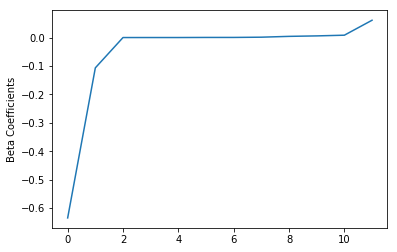

In [0]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

#### Summarize the model over the training set, we can also obtain the receiver-operating characteristic and areaUnderROC.


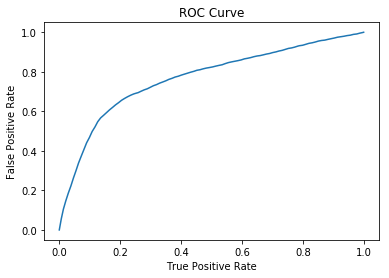

Training set areaUnderROC: 0.767144434832


In [0]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

#### Precision and recall.

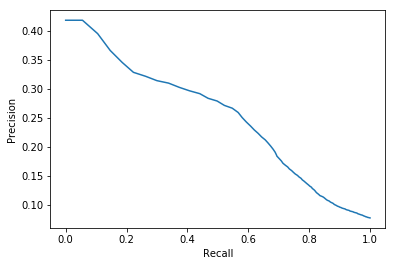

In [0]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

#### Make predictions on the test set.

In [0]:
predictions = lrModel.transform(test)
predictions.select('customer_city', 'customer_state', 'seller_city', 'seller_state','Weight/volume',  'customer_zip_code_prefix', 'freight/price', 'freight_value', 'price','product_height_cm', 'product_length_cm','product_weight_g', 'product_width_cm', 'review_score', 'seller_zip_code_prefix','Distance_Sell_Cust', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+--------------------+--------------+---------------+------------+--------------------+------------------------+-------------------+-------------+------+-----------------+-----------------+----------------+----------------+------------+----------------------+------------------+-----+--------------------+----------+--------------------+
|       customer_city|customer_state|    seller_city|seller_state|       Weight/volume|customer_zip_code_prefix|      freight/price|freight_value| price|product_height_cm|product_length_cm|product_weight_g|product_width_cm|review_score|seller_zip_code_prefix|Distance_Sell_Cust|label|       rawPrediction|prediction|         probability|
+--------------------+--------------+---------------+------------+--------------------+------------------------+-------------------+-------------+------+-----------------+-----------------+----------------+----------------+------------+----------------------+------------------+-----+--------------------+----------+--------

#### Evaluate our Logistic Regression model.

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

('Test Area Under ROC', 0.7648981809083307)


In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
print("Training: Area Under ROC: " + str(trainingSummary.areaUnderROC))
# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print("Test Area Under ROC " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Training: Area Under ROC: 0.767144434832
Test Area Under ROC 0.764898180908


In [0]:
evaluator.getMetricName()

'areaUnderROC'

#### Confusion matrix

In [0]:
cm_lr_result = predictions.crosstab("prediction", "label")
cm_lr_result = cm_lr_result.toPandas()
cm_lr_result

,prediction_label,0.0,1.0
0,1.0,3920,1426
1,0.0,27383,1191


#### Hyperparameter tuning
Try tuning the model with the ParamGridBuilder and the CrossValidator.

In [0]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)
print('Test Area Under ROC', evaluator.evaluate(predictions))

('Test Area Under ROC', 0.7662717046791144)


In [0]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np
lr = LogisticRegression(maxIter = 10)

paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, np.linspace(0.3, 0.01, 10)) \
    .addGrid(lr.elasticNetParam, np.linspace(0.3, 0.8, 6)) \
    .build()
    
crossval_lr =CrossValidator(estimator=lr,
                           estimatorParamMaps=paramGrid_lr,
                           evaluator=BinaryClassificationEvaluator(),
                           numFolds = 5)
cvModel_lr = crossval_lr.fit(train)

In [0]:
trainingSummary = lrModel.summary

In [0]:
best_model_lr = cvModel_lr.bestModel.summary
best_model_lr.predictions.columns

['label',
 'features',
 'Carrier_Late(1)/on-time(0)',
 'Carrier_Start_Date-Shipping_limit_Days',
 'Carrier_time_diff_Days',
 'Delivery_time_diff_Days',
 'Estimated-Actual_Delivery_Days',
 'Late(1)/on-time(0)',
 'Order_Approval_diff_Days',
 'Weight/volume',
 'customer_city',
 'customer_geolocation_lat',
 'customer_geolocation_lng',
 'customer_id',
 'customer_state',
 'customer_unique_id',
 'customer_zip_code_prefix',
 'freight/price',
 'freight_value',
 'id',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'order_id',
 'order_item_id',
 'order_purchase_timestamp',
 'order_status',
 'payment_type_count',
 'payment_type_value',
 'price',
 'product_category_name_english',
 'product_description_lenght',
 'product_height_cm',
 'product_id',
 'product_length_cm',
 'product_name_lenght',
 'product_photos_qty',
 'product_weight_g',
 'product_width_cm',
 'review_comment_message',
 'review_id',
 'review_score',
 'seller_c

As shown below, we see the data was fitted perfectly. We will see the models performance with the test data. We have to practice caution when the models show extraordinary performance with the training data as this can be due to overfitting problem which makes the model not to generalize to unseen data. Area under the curve for the training data

In [0]:
my_eval_lr = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label', metricName='areaUnderROC')
my_eval_lr.evaluate(best_model_lr.predictions)

0.5

In [0]:
train_fit_lr = best_model_lr.predictions.select('label','prediction')
train_fit_lr.groupBy('label','prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       0.0| 6098|
|  0.0|       0.0|72632|
+-----+----------+-----+



In [0]:
predictions_lr = cvModel_lr.transform(test)
#As you can see below, the predictions dataframe contains the original data and the predictions.
predictions_lr.columns

['label',
 'features',
 'Carrier_Late(1)/on-time(0)',
 'Carrier_Start_Date-Shipping_limit_Days',
 'Carrier_time_diff_Days',
 'Delivery_time_diff_Days',
 'Estimated-Actual_Delivery_Days',
 'Late(1)/on-time(0)',
 'Order_Approval_diff_Days',
 'Weight/volume',
 'customer_city',
 'customer_geolocation_lat',
 'customer_geolocation_lng',
 'customer_id',
 'customer_state',
 'customer_unique_id',
 'customer_zip_code_prefix',
 'freight/price',
 'freight_value',
 'id',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'order_id',
 'order_item_id',
 'order_purchase_timestamp',
 'order_status',
 'payment_type_count',
 'payment_type_value',
 'price',
 'product_category_name_english',
 'product_description_lenght',
 'product_height_cm',
 'product_id',
 'product_length_cm',
 'product_name_lenght',
 'product_photos_qty',
 'product_weight_g',
 'product_width_cm',
 'review_comment_message',
 'review_id',
 'review_score',
 'seller_c

In [0]:
predictions_lr.show(5)

+-----+--------------------+--------------------------+--------------------------------------+----------------------+-----------------------+------------------------------+------------------+------------------------+--------------------+--------------+------------------------+------------------------+--------------------+--------------+--------------------+------------------------+-------------------+-------------+------------+-------------------+----------------------------+-----------------------------+-----------------------------+--------------------+-------------+------------------------+------------+------------------+--------------------+-----+-----------------------------+--------------------------+-----------------+--------------------+-----------------+-------------------+------------------+----------------+----------------+----------------------+--------------------+------------+-----------+----------------------+----------------------+--------------------+------------+-----

In [0]:
predictions_lr.select('label', 'prediction').show(5)

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 5 rows



In [0]:
predictions_lr.groupBy('label','prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       0.0| 2617|
|  0.0|       0.0|31303|
+-----+----------+-----+



Area under the curve with the test data

In [0]:
my_eval_lr.evaluate(predictions_lr)

0.5

F1-score with the test data

In [0]:
my_mc_lr = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='f1')
my_mc_lr.evaluate(predictions_lr)

0.885819637396404

Acccuracy with the test data

In [0]:
my_mc_lr = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='accuracy')
my_mc_lr.evaluate(predictions_lr)

0.9228478773584906

#### LogisticRegressionTrainingSummary
LogisticRegressionTrainingSummary provides a summary for a LogisticRegressionModel. In the case of binary classification, certain additional metrics are available, e.g. ROC curve. See BinaryLogisticRegressionTrainingSummary. <br>
Reference: https://spark.apache.org/docs/latest/ml-classification-regression.html

In [0]:
trainingSummary = lrModel.summary

# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)

# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
trainingSummary.roc.show()
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

# Set the model threshold to maximize F-Measure
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']
lr.setThreshold(bestThreshold)

objectiveHistory:
0.272700994237
0.261053832196
0.246690513172
0.244124059396
0.243071424968
0.240367774935
0.239523876799
0.237564737356
0.235914349838
0.234584565324
0.232575856825
+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
|0.006444166586515341|0.055255844368154325|
|0.013492903172618476| 0.10511688736308648|
|0.021242391349152914| 0.14631355239496485|
|0.029541488616221714| 0.18587542913192742|
|0.038184091564874484|  0.2226581657675331|
| 0.04648318883194328|  0.2627104789929704|
| 0.05491968837164567|  0.2998201732875593|
| 0.06316382472966103| 0.33807421938858917|
| 0.07216367358716114|  0.3732221677292791|
| 0.08090245812665742|  0.4067353277750531|
| 0.08979238516605065| 0.44073892430930195|
| 0.09910825925060801|  0.4678764100049044|
| 0.10788826447189437|  0.4976295569723721|
| 0.11743772241992882|  0.5214974660781428|
| 0.12630016900479535|  0

LogisticRegression_5c018a4ec0e8

### Decision Tree Classifier
Decision trees are widely used since they are easy to interpret, handle categorical features, extend to the multi-class classification, do not require feature scaling, and are able to capture non-linearities and feature interactions.

In [0]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('customer_city', 'customer_state', 'seller_city', 'seller_state','Weight/volume',  'customer_zip_code_prefix', 'freight/price', 'freight_value', 'price','product_height_cm',\
                   'product_length_cm','product_weight_g', 'product_width_cm', 'review_score', 'seller_zip_code_prefix','Distance_Sell_Cust', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+--------------------+--------------+---------------+------------+--------------------+------------------------+-------------------+-------------+------+-----------------+-----------------+----------------+----------------+------------+----------------------+------------------+-----+----------------+----------+--------------------+
|       customer_city|customer_state|    seller_city|seller_state|       Weight/volume|customer_zip_code_prefix|      freight/price|freight_value| price|product_height_cm|product_length_cm|product_weight_g|product_width_cm|review_score|seller_zip_code_prefix|Distance_Sell_Cust|label|   rawPrediction|prediction|         probability|
+--------------------+--------------+---------------+------------+--------------------+------------------------+-------------------+-------------+------+-----------------+-----------------+----------------+----------------+------------+----------------------+------------------+-----+----------------+----------+--------------------

#### Evaluate our Decision Tree model.

In [0]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.5


#### Confusion matrix

In [0]:
cm_dt_result = predictions.crosstab("prediction", "label")
cm_dt_result = cm_dt_result.toPandas()
cm_dt_result

,prediction_label,0.0,1.0
0,0.0,31303,2617


One simple decision tree performed poorly because it is too weak given the range of different features. The prediction accuracy of decision trees can be improved by Ensemble methods, such as Random Forest and Gradient-Boosted Tree.

#####################################################################################################
########################### make some codes to plot the feature importances ######################################

I didn't do this because decision tree models has some problems.
#####################################################################################################

### Feature importances

In [0]:
dtModel.featureImportances

SparseVector(12, {})

In [0]:
features_columns = ['customer_city', 'customer_state', 'seller_city', 'seller_state', 'Weight/volume',  'customer_zip_code_prefix', 'freight/price',  'freight_value', 'price',\
                     'product_height_cm', 'product_length_cm','product_weight_g', 'product_width_cm', 'review_score', 'seller_zip_code_prefix','Distance_Sell_Cust']

In [0]:
feature_list = []
for col in features_columns:
    if col == 'label':
        continue
    else:
        feature_list.append(col)

Text(0.5,1,'Feature Importances')

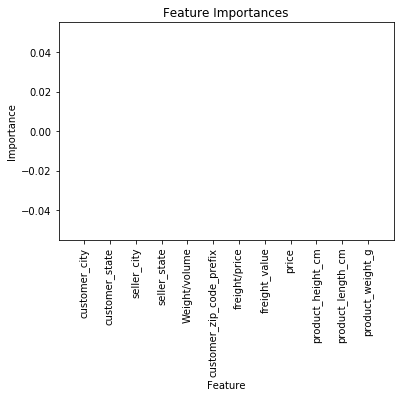

In [0]:
importances = dtModel.featureImportances

x_values = list(range(len(importances)))

plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

### Random Forest Classifier

In [0]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('customer_city', 'customer_state', 'seller_city', 'seller_state','Weight/volume',  'customer_zip_code_prefix', 'freight/price', 'freight_value', 'price','product_height_cm',\
                   'product_length_cm','product_weight_g', 'product_width_cm', 'review_score', 'seller_zip_code_prefix','Distance_Sell_Cust', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+--------------------+--------------+--------------+------------+--------------------+------------------------+-------------------+-------------+------+-----------------+-----------------+----------------+----------------+------------+----------------------+------------------+-----+--------------------+----------+--------------------+
|       customer_city|customer_state|   seller_city|seller_state|       Weight/volume|customer_zip_code_prefix|      freight/price|freight_value| price|product_height_cm|product_length_cm|product_weight_g|product_width_cm|review_score|seller_zip_code_prefix|Distance_Sell_Cust|label|       rawPrediction|prediction|         probability|
+--------------------+--------------+--------------+------------+--------------------+------------------------+-------------------+-------------+------+-----------------+-----------------+----------------+----------------+------------+----------------------+------------------+-----+--------------------+----------+-----------

#### Evaluate our Random Forest Classifier.

In [0]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.752312254723


Let's check the feature importances of random forest

In [0]:
print rfModel.featureImportances

(12,[0,1,2,3,4,5,6,7,8,9,10,11],[0.011406094279817817,0.21526553920722905,0.023517721785109743,0.02534246517358548,0.010025779784215271,0.014311852021442088,0.0027057603284674973,0.015159631529101898,0.0030482382369660076,0.5869726274082818,0.030674294790277314,0.06156999545550596])


### Confusion matrix

In [0]:
cm_dt_result = predictions.crosstab("prediction", "label")
cm_dt_result = cm_dt_result.toPandas()
cm_dt_result

,prediction_label,0.0,1.0
0,1.0,0,9
1,0.0,31156,2589


### Feature importances
- Reference <br>
(1) https://www.timlrx.com/2018/06/19/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator/ <br>
(2) https://www.silect.is/blog/2019/4/2/random-forest-in-spark-ml

In [0]:
importances = rfModel.featureImportances
features_columns = ['customer_city', 'customer_state', 'seller_city', 'seller_state', 'Weight/volume',  'customer_zip_code_prefix', 'freight/price',  'freight_value', 'price',\
                    'product_height_cm', 'product_length_cm','product_weight_g', 'product_width_cm', 'review_score', 'seller_zip_code_prefix','Distance_Sell_Cust']

In [0]:
model = pd.DataFrame(importances.toArray(), columns=["values"])
features_col = pd.Series(features_columns)
model["features"] = features_col
model

,values,features
0,0.011406,customer_city
1,0.215266,customer_state
2,0.023518,seller_city
3,0.025342,seller_state
4,0.010026,Weight/volume
5,0.014312,customer_zip_code_prefix
6,0.002706,freight/price
7,0.015160,freight_value
8,0.003048,price
9,0.586973,product_height_cm


In [0]:
y_pos = np.arange(len(features_columns))

In [0]:
from pyspark.sql.types import StructType, StructField, DoubleType, StringType
from IPython.display import display

new_schema = StructType([
  StructField("values", DoubleType(), False),
  StructField("features", StringType(), False)
])

feature_importance = spark.createDataFrame(model, schema=new_schema)

feature_importance.orderBy("values", ascending=False).show()

+--------------------+--------------------+
|              values|            features|
+--------------------+--------------------+
|  0.5869726274082818|   product_height_cm|
| 0.21526553920722905|      customer_state|
| 0.06156999545550596|    product_weight_g|
|0.030674294790277314|   product_length_cm|
| 0.02534246517358548|        seller_state|
|0.023517721785109743|         seller_city|
|0.015159631529101898|       freight_value|
|0.014311852021442088|customer_zip_code...|
|0.011406094279817817|       customer_city|
|0.010025779784215271|       Weight/volume|
|0.003048238236966...|               price|
|0.002705760328467...|       freight/price|
+--------------------+--------------------+



In [0]:
feature_importance.toPandas()

,values,features
0,0.011406,customer_city
1,0.215266,customer_state
2,0.023518,seller_city
3,0.025342,seller_state
4,0.010026,Weight/volume
5,0.014312,customer_zip_code_prefix
6,0.002706,freight/price
7,0.015160,freight_value
8,0.003048,price
9,0.586973,product_height_cm


In [0]:
features_columns = ['customer_city', 'customer_state', 'seller_city', 'seller_state', 'Weight/volume',  'customer_zip_code_prefix', 'freight/price',  'freight_value', 'price',\
                    'product_height_cm', 'product_length_cm','product_weight_g', 'product_width_cm', 'review_score', 'seller_zip_code_prefix','Distance_Sell_Cust']

In [0]:
feature_list = []
for col in features_columns:
    if col == 'label':
        continue
    else:
        feature_list.append(col)

Text(0.5,1,'Feature Importances')

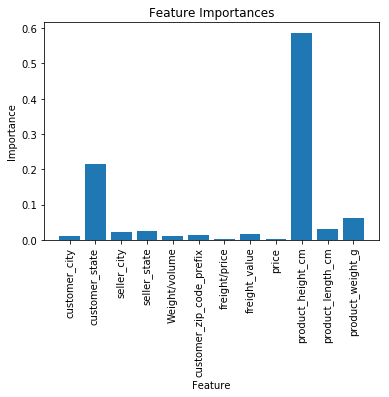

In [0]:
importances = rfModel.featureImportances

x_values = list(range(len(importances)))

plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

### Gradient-Boosted Tree Classifier

In [0]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('customer_city', 'customer_state', 'seller_city', 'seller_state','Weight/volume',  'customer_zip_code_prefix', 'freight/price', 'freight_value', 'price','product_height_cm',\
                    'product_length_cm','product_weight_g', 'product_width_cm', 'review_score', 'seller_zip_code_prefix','Distance_Sell_Cust','label', 'rawPrediction', 'prediction', 'probability').show(10)

+--------------------+--------------+--------------+------------+--------------------+------------------------+-------------------+-------------+------+-----------------+-----------------+----------------+----------------+------------+----------------------+------------------+-----+--------------------+----------+--------------------+
|       customer_city|customer_state|   seller_city|seller_state|       Weight/volume|customer_zip_code_prefix|      freight/price|freight_value| price|product_height_cm|product_length_cm|product_weight_g|product_width_cm|review_score|seller_zip_code_prefix|Distance_Sell_Cust|label|       rawPrediction|prediction|         probability|
+--------------------+--------------+--------------+------------+--------------------+------------------------+-------------------+-------------+------+-----------------+-----------------+----------------+----------------+------------+----------------------+------------------+-----+--------------------+----------+-----------

#### Evaluate our Gradient-Boosted Tree Classifier.

In [0]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.770788635371


Gradient-Boosted Tree achieved the best results, we will try tuning this model with the ParamGridBuilder and the CrossValidator. Before that we can use explainParams() to print a list of all params and their definitions to understand what params available for tuning.

In [0]:
print(gbt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

In [0]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.7753348863218933

#### Confusion matrix

In [0]:
cm_gbt_result = predictions.crosstab("prediction", "label")
cm_gbt_result = cm_gbt_result.toPandas()
cm_gbt_result

,prediction_label,0.0,1.0
0,1.0,109,142
1,0.0,31047,2456


### Naive Bayes

Naive Bayes classifiers are a family of simple probabilistic classifiers based on applying Bayes’ theorem with strong (naive) independence assumptions between the features. The spark.ml implementation currently supports both multinomial naive Bayes and Bernoulli naive Bayes.

In [0]:
from pyspark.ml.classification import NaiveBayes

# create the trainer and set its parameters
nb = NaiveBayes(smoothing=1)

# train the model
model = nb.fit(train)

In [0]:
predictions = model.transform(test)
predictions.filter(predictions['prediction'] == 0) \
    .select('customer_city', 'customer_state', 'seller_city', 'seller_state','Weight/volume',  'customer_zip_code_prefix', 'freight/price', 'freight_value', 'price','product_height_cm',\
                    'product_length_cm','product_weight_g', 'product_width_cm', 'review_score', 'seller_zip_code_prefix','Distance_Sell_Cust',"features","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+---------------------+--------------+---------------------+------------+--------------------+------------------------+-------------------+-------------+------+-----------------+-----------------+----------------+----------------+------------+----------------------+------------------+------------------------------+----------------------------+-----+----------+
|        customer_city|customer_state|          seller_city|seller_state|       Weight/volume|customer_zip_code_prefix|      freight/price|freight_value| price|product_height_cm|product_length_cm|product_weight_g|product_width_cm|review_score|seller_zip_code_prefix|Distance_Sell_Cust|                      features|                 probability|label|prediction|
+---------------------+--------------+---------------------+------------+--------------------+------------------------+-------------------+-------------+------+-----------------+-----------------+----------------+----------------+------------+----------------------+--------

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
print("Training: Area Under ROC: " + str(trainingSummary.areaUnderROC))

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Training: Area Under ROC: 0.767144434832
Test: Area Under ROC: 0.49545069308


In [0]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np
nb = NaiveBayes()
paramGrid_nb = ParamGridBuilder() \
    .addGrid(nb.smoothing, np.linspace(0.3, 0.01,10)) \
    .build()
    
crossval_nb =CrossValidator(estimator=nb,
                           estimatorParamMaps=paramGrid_nb,
                           evaluator=BinaryClassificationEvaluator(),
                           numFolds = 5)
cvModel_nb = crossval_lr.fit(train)

In [0]:
cvModel_nb.avgMetrics

[0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.7565773961461737,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.7565773961461737,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.7565773961461737,
 0.7565773961461737,
 0.5,
 0.5,
 0.5,
 0.5,
 0.7565773961461737,
 0.7565773961461737,
 0.5,
 0.5,
 0.5,
 0.5,
 0.7565773961461737,
 0.7565773961461737,
 0.7565773961461737,
 0.5,
 0.5,
 0.5,
 0.7565773961461737,
 0.7565773961461737,
 0.7565773961461737,
 0.7565773961461737,
 0.7565773961461737,
 0.5,
 0.7639971922043844,
 0.7565773961461737,
 0.7565773961461737,
 0.7565773961461737,
 0.7565773961461737,
 0.7565773961461737,
 0.762351333548529,
 0.7624167018508488,
 0.7629629982700051,
 0.7631163781132274,
 0.7577245129210816,
 0.7565773961461737,
 0.754073334356233,
 0.7553861513284343,
 0.7603433640475871,
 0.7622673765691205,
 0.761303992213591,
 0.7634120115743712]

In [0]:
# Make predictions:
predictions_nb = cvModel_nb.transform(test)
predictions_nb.select('label','prediction').show(5)

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 5 rows



In [0]:
my_eval_nb = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label', metricName='areaUnderROC')
my_eval_nb.evaluate(predictions_nb)

0.5

In [0]:
my_mc_nb = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='accuracy')
my_mc_nb.evaluate(predictions_nb)

0.9228478773584906

In [0]:
my_mc_nb = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='f1')
my_mc_nb.evaluate(predictions_nb)

0.885819637396404

### Linear Support Vector Machine
A support vector machine constructs a hyperplane or set of hyperplanes in a high- or infinite-dimensional space, which can be used for classification, regression, or other tasks. Intuitively, a good separation is achieved by the hyperplane that has the largest distance to the nearest training-data points of any class (so-called functional margin), since in general the larger the margin the lower the generalization error of the classifier. LinearSVC in Spark ML supports binary classification with linear SVM. Internally, it optimizes the Hinge Loss using OWLQN optimizer.

In [0]:
from pyspark.ml.classification import LinearSVC

lsvc = LinearSVC(maxIter=10, regParam=0.1)

# Fit the model
lsvcModel = lsvc.fit(train)

# Print the coefficients and intercept for linear SVC
print("Coefficients: " + str(lsvcModel.coefficients))
print("Intercept: " + str(lsvcModel.intercept))

Coefficients: [-0.07276232451499678,-4.861705188003688e-07,-0.2930068828074253,-5.977187265123054e-06,-1.4874717408231739e-05,-0.003235510584297877,-0.004327966246084948,2.492488078688008e-05,-0.007909261866316573,-0.08113659589201568,-2.0762215003510064e-06,4.836932832289592e-05]
Intercept: -0.439790319272


In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
predictions = lsvcModel.transform(test)
print('Test Area Under ROC', evaluator.evaluate(predictions))

('Test Area Under ROC', 0.7071847308600059)


#### Confusion matrix

In [0]:
cm_svm_result = predictions.crosstab("prediction", "label")
cm_svm_result = cm_svm_result.toPandas()
cm_svm_result

,prediction_label,0.0,1.0
0,0.0,31303,2617


### Multilayer perceptron classifier
Multilayer perceptron classifier (MLPC) is a classifier based on the feedforward artificial neural network. MLPC consists of multiple layers of nodes. Each layer is fully connected to the next layer in the network. Nodes in the input layer represent the input data. All other nodes map inputs to outputs by a linear combination of the inputs with the node’s weights w and bias b and applying an activation function. This can be written in matrix form for MLPC with K+1 layers as follows: y(x)=fK(...f2(wT2f1(wT1x+b1)+b2)...+bK) Nodes in intermediate layers use sigmoid (logistic) function: f(zi)=11+e−zi Nodes in the output layer use softmax function: f(zi)=ezi∑Nk=1ezk The number of nodes N in the output layer corresponds to the number of classes.
MLPC employs backpropagation for learning the model. We use the logistic loss function for optimization and L-BFGS as an optimization routine.

In [0]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Split the data into train and test
splits = final_order3.randomSplit([0.7, 0.3], 1234)
train = splits[0]
test = splits[1]

# specify layers for the neural network:
# input layer of size 12 (features), two intermediate of size 3 and 2
# and output of size 2 (classes)
layers = [12, 3, 2, 2]

# create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234)

# train the model
model = trainer.fit(train)

# compute accuracy on the test set
result = model.transform(test)
predictionAndLabels = result.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Test set accuracy = " + str(evaluator.evaluate(predictionAndLabels)))

Test set accuracy = 0.922847877358


To sum it up, we have learned how to build a binary classification application using PySpark and MLlib Pipelines API. We tried four algorithms and neural network performed best on our data set.